# 统计各类数量（分模型）

In [1]:
from datasets import load_dataset


label2num = {
    'explicitly-supported': 6, 
    'generally-supported': 5, 
    'implicitly-supported': 5, 
    'out-dependent': 4,
    'ambiguous': 3,
    'not sure': 3,
    'fabricated': 2, 
    'inconsistent': 1, 
    'contradicting': 1,
    'no-fact': 0
}

ds = load_dataset('json', data_files='/home/dingqiang/hallucination_detection/FaithBench_sentence_level_reannotated_20251007.jsonl')['train']
models = [n.split('/')[-1].lower() for n in ds.unique('generator')]

statistics = {m: [0]*7 for m in models}
sentences = ds['sentences']
generator = ds['generator']
for i in range(len(ds)):
    for j in range(len(sentences[i])):
        try:
            statistics[generator[i].split('/')[-1].lower()][label2num[sentences[i][j]['annotation'].lower()]] += 1
        except:
            print(sentences[i][j]['annotation'].lower())

/home/dingqiang/miniconda3/envs/augment3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 412 examples [00:00, 25671.91 examples/s]


In [2]:
# plot the statistics in one figure
import matplotlib.pyplot as plt
import numpy as np


labels = ['inconsistent', 'fabricated', 'ambiguous', 'out-dependent', 'implicitly-supported', 'explicitly-supported', 'no-fact']
models = list(statistics.keys())
# sort models by performance (percentage of non-hallucination)
models.sort(key=lambda m: (statistics[m][label2num['fabricated']] + statistics[m][label2num['inconsistent']]) / sum(statistics[m]), reverse=True)

x = np.arange(len(models)+1)  # the label locations
width = 0.8  # the width of the bars
fig, ax = plt.subplots(figsize=(12, 5))
bottom = np.zeros(len(models)+1)
for i, label in enumerate(labels):
    values = np.array([statistics[m][label2num[label]] / sum(statistics[m]) for m in models]+[sum([statistics[m][label2num[label]] for m in models])/sum([sum(statistics[m]) for m in models])])
    ax.bar(x, values, width, label=label, bottom=bottom, edgecolor='black')
    bottom += values
ax.set_ylabel('Percentage')
ax.set_title('Model-wise Annotation Statistics')
ax.set_xticks(x, labels=[m.lower() for m in models]+['Total'], rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
# plt.show()
plt.savefig('figs/model_wise_annotation_statistics.pdf')
plt.close()

In [3]:
for label in labels:
    print(sum([statistics[m][label2num[label]] for m in models])/sum([sum(statistics[m]) for m in models]))

0.026418786692759294
0.11399217221135029
0.004403131115459882
0.08610567514677103
0.13258317025440314
0.6281800391389433
0.008317025440313111


In [4]:
for label in labels:
    values = np.array([statistics[m][label2num[label]] / sum(statistics[m]) for m in models])
    print(label, values)

inconsistent [0.0625     0.06299213 0.03759398 0.03968254 0.00729927 0.03053435
 0.03225806 0.02430556 0.02597403 0.00775194 0.00680272 0.
 0.00671141]
fabricated [0.22596154 0.15748031 0.17293233 0.13492063 0.1459854  0.11450382
 0.10483871 0.10763889 0.0974026  0.06976744 0.06122449 0.05759162
 0.02013423]
ambiguous [0.         0.00787402 0.01503759 0.00793651 0.         0.01526718
 0.         0.00347222 0.00649351 0.         0.         0.
 0.00671141]
out-dependent [0.07211538 0.01574803 0.03759398 0.05555556 0.10218978 0.09160305
 0.06451613 0.14930556 0.07142857 0.01550388 0.06122449 0.15183246
 0.12751678]
implicitly-supported [0.125      0.11811024 0.13533835 0.08730159 0.17518248 0.09923664
 0.12096774 0.18055556 0.07142857 0.06976744 0.11564626 0.14659686
 0.2147651 ]
explicitly-supported [0.51442308 0.61417323 0.60150376 0.66666667 0.56934307 0.63358779
 0.67741935 0.5        0.72727273 0.8372093  0.75510204 0.64397906
 0.61744966]
no-fact [0.         0.02362205 0.         0.

# 比较现在标注和原始标注

In [5]:
from datasets import load_dataset


original2current = {
    '': 'explicitly-supported',
    'benign': 'out-dependent',
    'questionable': 'ambiguous',
    'unwanted': 'fabricated',
    'unwanted.extrinsic': 'fabricated',
    'unwanted.instrinsic': 'inconsistent',
}

severity = {
    '': 0,
    'benign': 1,
    'questionable': 2,
    'unwanted': 3,
    'unwanted.extrinsic': 4,
    'unwanted.instrinsic': 5,
}


def majority_voting(annotation):
    annotations = annotation.split('|')
    if len(annotations) == 1:
        return annotations[0].strip().lower()
    candidate = dict()
    for a in annotations:
        a = a.strip().lower()
        if a not in candidate:
            candidate[a] = 0
        candidate[a] += 1
    sorted_candidate = sorted(candidate.items(), key=lambda x: x[1], reverse=True)
    if len(sorted_candidate) == 1:
        return sorted_candidate[0][0]
    if sorted_candidate[0][1] > sorted_candidate[1][1]:
        return sorted_candidate[0][0]

    # tie break
    tied_candidates = [c for c in sorted_candidate if c[1] == sorted_candidate[0][1]]
    sorted_candidate = sorted(tied_candidates, key=lambda x: severity[x[0]], reverse=True)
    return sorted_candidate[0][0]


current_ds = load_dataset('json', data_files='FaithBench_sentence_level_reannotated_20251007.jsonl')['train'].select(range(277))
original_ds = load_dataset('json', data_files='/home/dingqiang/FaithBench/FaithBench_sentence_level_20250829.jsonl')['train']

current_annotations = []
for sentences in current_ds['sentences']:
    current_annotations.extend([s['annotation'].lower() for s in sentences] )

original_annotations = []
for sentences in original_ds['sentences']:
    original_annotations.extend([original2current[majority_voting(s['annotation'])] for s in sentences])

Generating train split: 412 examples [00:00, 42535.65 examples/s]
Generating train split: 277 examples [00:00, 12528.68 examples/s]


In [6]:
for i in range(277):
    if (current_annotations[i] != original_annotations[i]) and original_annotations[i] in ['out-dependent', 'ambiguous']:
        print(f'Index {i+1}: Current: {current_annotations[i]}, Original: {original_annotations[i]}')

Index 2: Current: explicitly-supported, Original: ambiguous
Index 7: Current: fabricated, Original: ambiguous
Index 12: Current: fabricated, Original: ambiguous
Index 17: Current: fabricated, Original: out-dependent
Index 18: Current: fabricated, Original: out-dependent
Index 22: Current: implicitly-supported, Original: ambiguous
Index 24: Current: fabricated, Original: ambiguous
Index 31: Current: fabricated, Original: ambiguous
Index 35: Current: fabricated, Original: ambiguous
Index 46: Current: out-dependent, Original: ambiguous
Index 51: Current: ambiguous, Original: out-dependent
Index 58: Current: explicitly-supported, Original: ambiguous
Index 63: Current: fabricated, Original: ambiguous
Index 72: Current: explicitly-supported, Original: out-dependent
Index 76: Current: fabricated, Original: ambiguous
Index 88: Current: out-dependent, Original: ambiguous
Index 102: Current: implicitly-supported, Original: ambiguous
Index 107: Current: fabricated, Original: ambiguous
Index 118: 

In [7]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(
    current_annotations, 
    original_annotations,
    labels=[
        'explicitly-supported', 
        'implicitly-supported', 
        'out-dependent', 
        'ambiguous', 
        'fabricated', 
        'inconsistent', 
        'no-fact'
    ][::-1]
)

In [8]:
cm

array([[  0,   0,   2,   2,   0,   0,   3],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,  57,   8,  14,  13,   0,  52],
       [  0,   0,   0,   1,   2,   0,   5],
       [  0,  15,   2,  11,  30,   0,  31],
       [  0,  16,   2,   9,  16,   0, 122],
       [  0,  36,   9,  22,  27,   0, 816]])

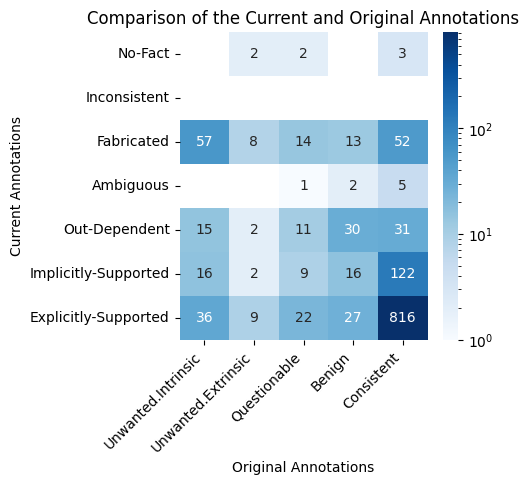

In [9]:
# 根据 confusion matric 画图
# 颜色使用对数标度

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import seaborn as sns

plt.figure(figsize=(4, 4))
sns.heatmap(np.concatenate([cm[:,1:5], cm[:,6:]], axis=1), annot=True, fmt='d', cmap='Blues', norm=LogNorm(), xticklabels=[
        'Consistent', 
        'Benign',
        'Questionable', 
        'Unwanted.Extrinsic', 
        'Unwanted.Intrinsic', 
    ][::-1], yticklabels=[
        'Explicitly-Supported', 
        'Implicitly-Supported', 
        'Out-Dependent', 
        'Ambiguous', 
        'Fabricated', 
        'Inconsistent', 
        'No-Fact'
    ][::-1])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Original Annotations')
plt.ylabel('Current Annotations')
plt.title('Comparison of the Current and Original Annotations')
plt.show()

In [10]:
# 检查标注有问题的 sentences

original_sentences = original_ds['sentences']
current_sentences = current_ds['sentences']
for i in range(len(original_ds)):
    for j in range(len(original_sentences[i])):
        if ('' == majority_voting(original_sentences[i][j]['annotation'])) and (current_sentences[i][j]['annotation'].lower() == 'inconsistent'):
            print(i+1, j+1)

# 统计幻觉首次出现位置

In [11]:
from datasets import load_dataset

ds = load_dataset('json', data_files='/home/dingqiang/hallucination_detection/FaithBench_sentence_level_reannotated_20251007.jsonl')['train']

sentences = ds['sentences']
first_hallucination_positions = []
response_lens = []
for i in range(len(ds)):
    response_lens.append(len(sentences[i]))
    first_hallucination_pos = -1
    for j in range(len(sentences[i])):
        if sentences[i][j]['annotation'].lower() in ['fabricated', 'inconsistent']:
            first_hallucination_pos = j + 1
            break
    first_hallucination_positions.append(first_hallucination_pos)

In [12]:
print(len(response_lens))
print(len(first_hallucination_positions))

412
412


In [13]:
filtered_response_lens = []
filtered_first_hallucination_positions = []
for i in range(len(sentences)):
    if first_hallucination_positions[i] != -1:
        filtered_response_lens.append(response_lens[i])
        filtered_first_hallucination_positions.append(first_hallucination_positions[i])


In [14]:
print(len(filtered_response_lens))
print(len(filtered_first_hallucination_positions))

167
167


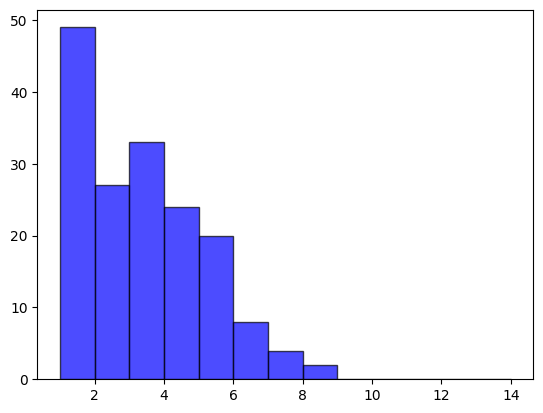

In [15]:
# 画出绝对位置统计图
import matplotlib.pyplot as plt

plt.hist(filtered_first_hallucination_positions, bins=range(1, max(filtered_response_lens)+1), alpha=0.7, color='blue', edgecolor='black')
plt.show()


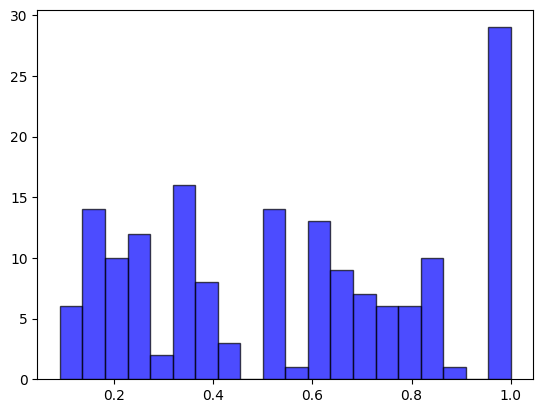

In [16]:
# 画出相对位置统计图

plt.hist([filtered_first_hallucination_positions[i]/filtered_response_lens[i] for i in range(len(filtered_response_lens))], bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.show()

In [17]:
# 画出每个位置的 sentence 的产生幻觉的概率
max_len = max(response_lens)
hallucinations = [0]*max_len
counts = [0]*max_len
for i in range(len(sentences)):
    for j in range(response_lens[i]):
        counts[j] += 1
        if sentences[i][j]['annotation'].lower() in ['fabricated', 'inconsistent']:
            hallucinations[j] += 1

In [18]:
hallucinations

[49, 33, 44, 46, 34, 17, 6, 2, 2, 0, 0, 0, 0, 0]

In [19]:
counts

[412, 410, 388, 317, 230, 139, 70, 38, 21, 9, 6, 2, 1, 1]

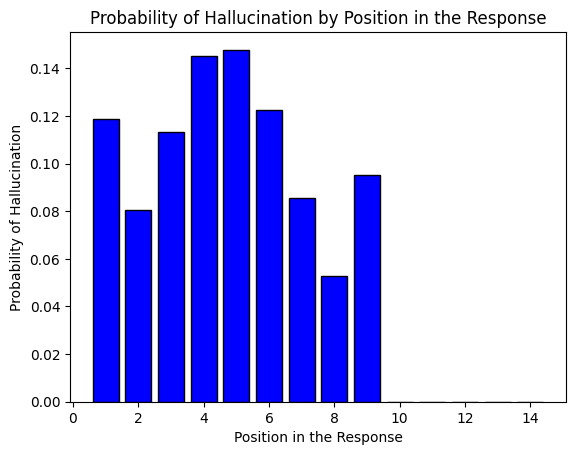

In [20]:
plt.bar(range(1, max_len+1), [hallucinations[i]/counts[i] if counts[i] > 0 else 0 for i in range(max_len)], color='blue', edgecolor='black')
plt.xlabel('Position in the Response')
plt.ylabel('Probability of Hallucination')
plt.title('Probability of Hallucination by Position in the Response')
plt.show()

PearsonRResult(statistic=np.float64(0.23252290149562457), pvalue=np.float64(1.8339753415188483e-06))


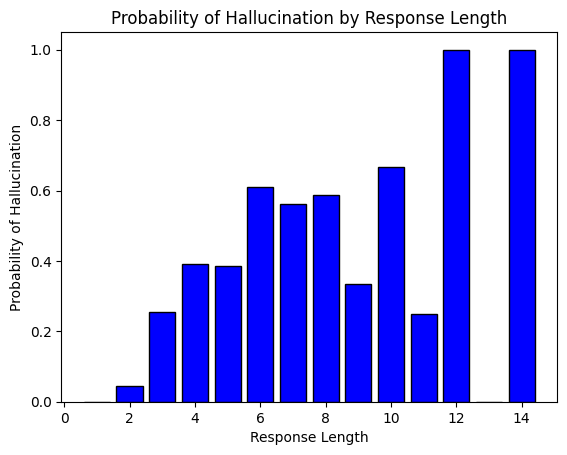

[0, 1, 18, 34, 35, 42, 18, 10, 4, 2, 1, 1, 0, 1]
[2, 22, 71, 87, 91, 69, 32, 17, 12, 3, 4, 1, 0, 1]


In [21]:
# 计算幻觉与长度的相关性

import scipy.stats as ss


print(ss.pearsonr(response_lens, [1 if first_hallucination_positions[i] != -1 else 0 for i in range(len(response_lens))]))

# 每个长度下 response 出现幻觉的概率

response_hallucinations = [0]*max_len
response_counts = [0]*max_len
for i in range(len(ds)):
    if first_hallucination_positions[i] != -1:
        response_hallucinations[response_lens[i]-1] += 1
    response_counts[response_lens[i]-1] += 1

plt.bar(range(1, max_len+1), [response_hallucinations[i]/response_counts[i] if response_counts[i] > 0 else 0 for i in range(max_len)], color='blue', edgecolor='black')
plt.xlabel('Response Length')
plt.ylabel('Probability of Hallucination')
plt.title('Probability of Hallucination by Response Length')
plt.show()

print(response_hallucinations)
print(response_counts)

In [22]:
# 每个句子出现幻觉的概率
print(sum(hallucinations)/sum(counts))

0.11399217221135029


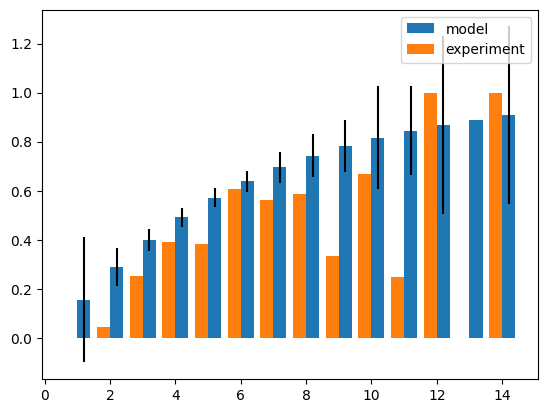

In [23]:
# 模拟的各个长度的 resposne 的幻觉频率
import numpy as np

errors = [np.sqrt((0.1559633027522936)*(1-0.1559633027522936)/response_counts[i]) if response_counts[i] > 0 else 0 for i in range(max_len)]
plt.bar(np.arange(1, max_len+1)+0.2, [1-(1-0.1559633027522936)**(i+1) for i in range(max_len)], width=0.4, yerr=errors, label='model')
plt.bar(np.arange(1, max_len+1)-0.2, [response_hallucinations[i]/response_counts[i] if response_counts[i] > 0 else 0 for i in range(max_len)], width=0.4, label='experiment')
plt.legend()
plt.show()

In [24]:
# 将转移矩阵转换为 p(faithful / unfaithful | explicitly-supported / implicitly-supported / fabricated / inconsistent)，然后打印出一个 latex 列表记录它们
from scipy import stats
from matplotlib import pyplot as plt


def print_transition_table(transition_count_matrix):
    transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)

    p = np.zeros((4,2))
    p[0][0] = transition_matrix[6][6] + transition_matrix[6][5]
    p[0][1] = transition_matrix[6][1] + transition_matrix[6][2]
    p[1][0] = transition_matrix[5][6] + transition_matrix[5][5]
    p[1][1] = transition_matrix[5][1] + transition_matrix[5][2]
    p[2][0] = transition_matrix[2][6] + transition_matrix[2][5]
    p[2][1] = transition_matrix[2][1] + transition_matrix[2][2]
    p[3][0] = transition_matrix[1][6] + transition_matrix[1][5]
    p[3][1] = transition_matrix[1][1] + transition_matrix[1][2]

    # 计算转移矩阵的方差
    err = np.zeros((4,2))
    err[0][0] = np.sqrt(p[0][0]*(1-p[0][0])/(transition_count_matrix[6].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[6].sum()-1)
    err[0][1] = np.sqrt(p[0][1]*(1-p[0][1])/(transition_count_matrix[6].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[6].sum()-1)
    err[1][0] = np.sqrt(p[1][0]*(1-p[1][0])/(transition_count_matrix[5].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[5].sum()-1)
    err[1][1] = np.sqrt(p[1][1]*(1-p[1][1])/(transition_count_matrix[5].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[5].sum()-1)
    err[2][0] = np.sqrt(p[2][0]*(1-p[2][0])/(transition_count_matrix[2].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[2].sum()-1)
    err[2][1] = np.sqrt(p[2][1]*(1-p[2][1])/(transition_count_matrix[2].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[2].sum()-1)
    err[3][0] = np.sqrt(p[3][0]*(1-p[3][0])/(transition_count_matrix[1].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[1].sum()-1)
    err[3][1] = np.sqrt(p[3][1]*(1-p[3][1])/(transition_count_matrix[1].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[1].sum()-1)

    prefix = r"""
\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    """
    postfix = r"""
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    """
    template = """
    Explicitly-Supported & ${:.2f}\\pm{:.2f}$ & ${:.2f}\\pm{:.2f}$ \\\\
    Implicitly-Supported & ${:.2f}\\pm{:.2f}$ & ${:.2f}\\pm{:.2f}$ \\\\
    Fabricated & ${:.2f}\\pm{:.2f}$ & ${:.2f}\\pm{:.2f}$ \\\\
    Inconsistent & ${:.2f}\\pm{:.2f}$ & ${:.2f}\\pm{:.2f}$ \\\\
    \\bottomrule
    """

    print(prefix + template.format(
        p[0][0], err[0][0],
        p[0][1], err[0][1],
        p[1][0], err[1][0],
        p[1][1], err[1][1],
        p[2][0], err[2][0],
        p[2][1], err[2][1],
        p[3][0], err[3][0],
        p[3][1], err[3][1],
    ) + postfix)


# 使用带有 error bar 的柱状图画出 transition matrix
def plot_transition_figure(transition_count_matrix, title=None, name=None):
    transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)

    p = np.zeros((7,3))
    for i in range(len(p)):
        p[i][0] = transition_matrix[i][5:].sum()  # faithful
        p[i][1] = transition_matrix[i][1:3].sum()  # unfaithful
        p[i][2] = transition_matrix[i][3:5].sum() + transition_matrix[i][0]  # others
        # p[i][3] = transition_matrix[i][0]  # no-fact

    err = np.zeros((7,3))
    for i in range(len(err)):
        err[i][0] = np.sqrt(p[i][0]*(1-p[i][0])/(transition_count_matrix[i].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[i].sum()-1)
        err[i][1] = np.sqrt(p[i][1]*(1-p[i][1])/(transition_count_matrix[i].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[i].sum()-1)
        err[i][2] = np.sqrt(p[i][2]*(1-p[i][2])/(transition_count_matrix[i].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[i].sum()-1)
        # err[i][3] = np.sqrt(p[i][3]*(1-p[i][3])/(transition_count_matrix[i].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[i].sum()-1)
    
    # 画图
    fig = plt.figure(figsize=(5, 4))
    labels = ['To Faithful', 'To Unfaithful', 'To Others']
    x = np.arange(len(labels))
    width = 0.1
    for i in range(7):
        plt.errorbar(x + i*width, p[i], yerr=err[i], fmt='o', markersize=3, capsize=5, capthick=2, elinewidth=2,
             alpha=0.8, markerfacecolor='white', markeredgewidth=2,
             label=[
                 'No-Fact', 
                 'Inconsistent', 
                 'Fabricated', 
                 'Ambiguous', 
                 'Out-Dependent', 
                 'Implicitly-Supported', 
                 'Explicitly-Supported'
             ][i])
    plt.xticks(x + 3*width, labels)
    plt.xlabel('Target', fontsize=12)
    plt.ylabel('Transition Probability', fontsize=12)
    if title is not None:
        plt.title(title)
    plt.legend(title='Source')
    plt.grid()
    plt.tight_layout()
    if name is not None:
        plt.savefig(f'figs/transition_probabilities_{name}.pdf')
    else:
        plt.savefig('figs/transition_probabilities.pdf')

[[  1.   0.   0.   0.   2.   0.   3.]
 [  0.   2.   8.   0.   2.   7.  24.]
 [  1.   6.  31.   1.  15.  25. 101.]
 [  0.   0.   1.   0.   0.   0.   7.]
 [  1.   2.  11.   0.  29.  14.  86.]
 [  1.   7.  23.   1.  19.  56.  99.]
 [  7.  27. 110.   5.  56. 123. 718.]]

\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    
    Explicitly-Supported & $0.80\pm0.02$ & $0.13\pm0.02$ \\
    Implicitly-Supported & $0.75\pm0.06$ & $0.15\pm0.05$ \\
    Fabricated & $0.70\pm0.07$ & $0.21\pm0.06$ \\
    Inconsistent & $0.72\pm0.14$ & $0.23\pm0.13$ \\
    \bottomrule
    
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    


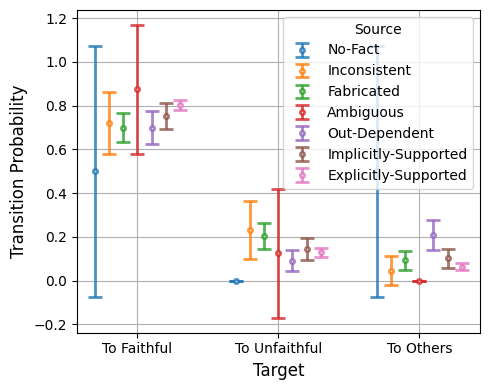

In [25]:
# 计算马尔可夫过程的转移矩阵
transition_matrix = np.zeros((7, 7))

for i in range(len(sentences)):
    for j in range(len(sentences[i]) -1):
        current_state = label2num.get(sentences[i][j]['annotation'].lower(), 3)  # ambiguous by default
        next_state = label2num.get(sentences[i][j+1]['annotation'].lower(), 3)  # ambiguous by default
        transition_matrix[current_state][next_state] += 1
print(transition_matrix)
transition_count_matrix = transition_matrix.copy()
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
print_transition_table(transition_count_matrix)
plot_transition_figure(transition_count_matrix)

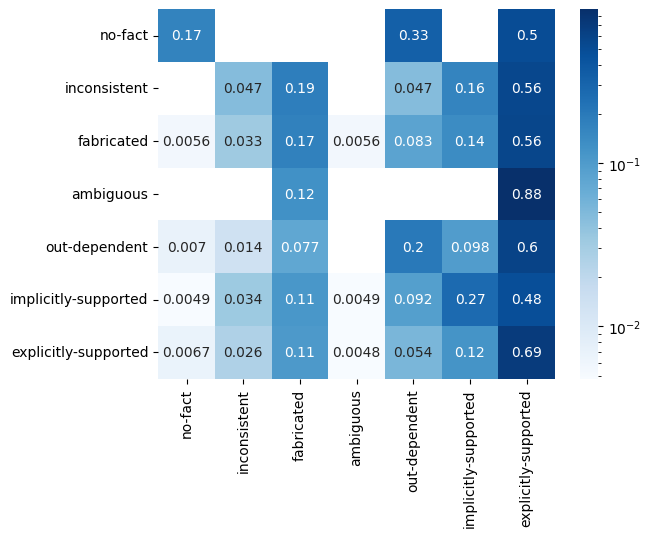

In [26]:
import seaborn as sns
from matplotlib.colors import LogNorm

sns.heatmap(transition_matrix, annot=True, cmap='Blues', norm=LogNorm())
plt.xticks(np.arange(0, 7)+0.5, ['no-fact', 'inconsistent', 'fabricated', 'ambiguous', 'out-dependent', 'implicitly-supported', 'explicitly-supported'], rotation=90)
plt.yticks(np.arange(0, 7)+0.5, ['no-fact', 'inconsistent', 'fabricated', 'ambiguous', 'out-dependent', 'implicitly-supported', 'explicitly-supported'], rotation=0)
# plt.colorbar()
plt.show()


In [27]:
# get the singular values of the transition matrix
u, s, vh = np.linalg.svd(transition_matrix)
print(s)

[1.71667898 0.36095514 0.27529431 0.08477689 0.06199716 0.01213519
 0.00502784]


In [28]:
s[:6].sum() / s.sum()

np.float64(0.9980023407517812)

[[  0.   0.   1.   0.   0.   0.   4.]
 [  0.   0.   3.   0.   1.   5.  20.]
 [  1.   4.  22.   1.  10.  17.  87.]
 [  1.   0.   0.   0.   1.   0.   4.]
 [  0.   2.   9.   0.  18.  12.  60.]
 [  1.   7.  16.   1.  15.  38.  78.]
 [  7.  21. 100.   2.  48. 112. 493.]]

\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    
    Explicitly-Supported & $0.77\pm0.03$ & $0.15\pm0.03$ \\
    Implicitly-Supported & $0.74\pm0.07$ & $0.15\pm0.06$ \\
    Fabricated & $0.73\pm0.07$ & $0.18\pm0.06$ \\
    Inconsistent & $0.86\pm0.13$ & $0.10\pm0.12$ \\
    \bottomrule
    
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    


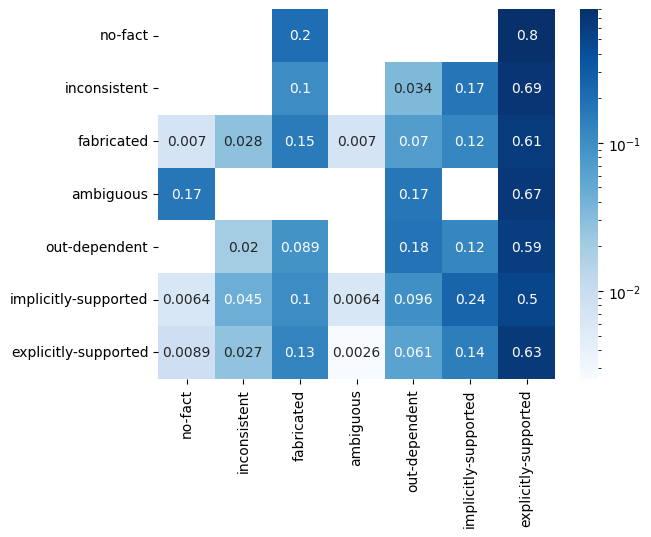

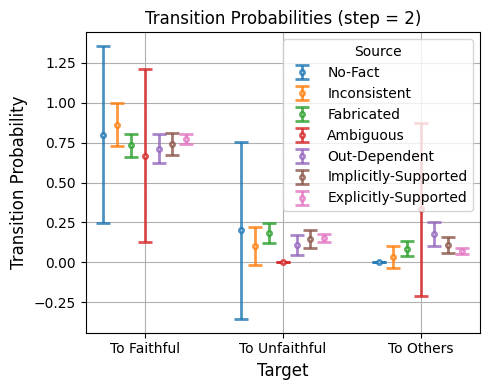

In [29]:
# 计算跳步的转移矩阵

transition_matrix_2 = np.zeros((7, 7))
for i in range(len(sentences)):
    for j in range(len(sentences[i]) -2):
        current_state = label2num[sentences[i][j]['annotation'].lower()]
        next_state = label2num[sentences[i][j+2]['annotation'].lower()]
        transition_matrix_2[current_state][next_state] += 1
print(transition_matrix_2)
transition_count_matrix_2 = transition_matrix_2.copy()
print_transition_table(transition_count_matrix_2)
transition_matrix_2 = transition_matrix_2 / transition_matrix_2.sum(axis=1, keepdims=True)

sns.heatmap(transition_matrix_2, annot=True, cmap='Blues', norm=LogNorm())
plt.xticks(np.arange(0, 7)+0.5, ['no-fact', 'inconsistent', 'fabricated', 'ambiguous', 'out-dependent', 'implicitly-supported', 'explicitly-supported'], rotation=90)
plt.yticks(np.arange(0, 7)+0.5, ['no-fact', 'inconsistent', 'fabricated', 'ambiguous', 'out-dependent', 'implicitly-supported', 'explicitly-supported'], rotation=0)
# plt.colorbar()
plt.show()

plot_transition_figure(transition_count_matrix_2, title='Transition Probabilities (step = 2)', name='step_2')

In [30]:
u, s, vh = np.linalg.svd(transition_matrix_2)
print(s)

[1.77668020e+00 2.66624307e-01 2.31436013e-01 9.41606627e-02
 5.22421615e-02 6.52358440e-03 1.10890082e-03]


[[  0.   0.   0.   0.   3.   0.   2.]
 [  0.   0.   3.   0.   1.   5.  14.]
 [  0.   2.  14.   0.   7.  10.  56.]
 [  0.   0.   2.   0.   0.   1.   1.]
 [  2.   1.   9.   0.  12.   7.  40.]
 [  1.   3.  13.   1.   9.  29.  64.]
 [  7.  13.  66.   3.  37.  86. 310.]]

\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    
    Explicitly-Supported & $0.76\pm0.04$ & $0.15\pm0.03$ \\
    Implicitly-Supported & $0.78\pm0.08$ & $0.13\pm0.06$ \\
    Fabricated & $0.74\pm0.09$ & $0.18\pm0.08$ \\
    Inconsistent & $0.83\pm0.17$ & $0.13\pm0.15$ \\
    \bottomrule
    
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    


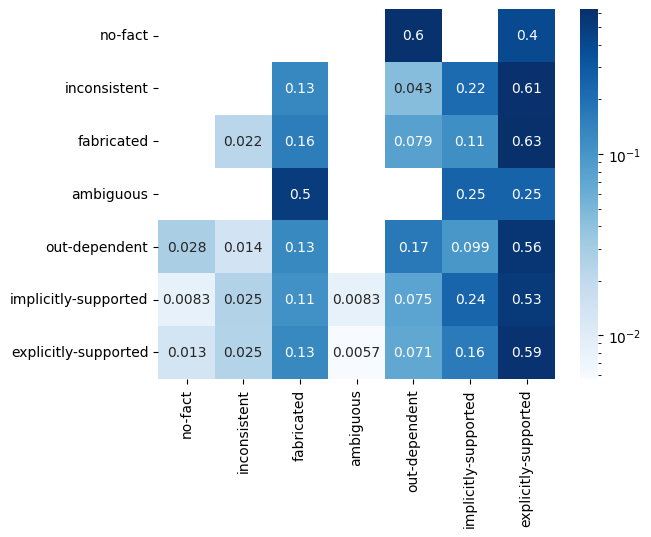

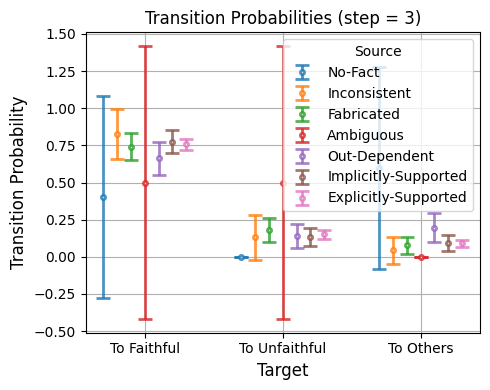

In [31]:
# 计算跳步的转移矩阵

transition_matrix_3 = np.zeros((7, 7))
for i in range(len(sentences)):
    for j in range(len(sentences[i]) -3):
        current_state = label2num[sentences[i][j]['annotation'].lower()]
        next_state = label2num[sentences[i][j+3]['annotation'].lower()]
        transition_matrix_3[current_state][next_state] += 1
print(transition_matrix_3)
transition_count_matrix_3 = transition_matrix_3.copy()
print_transition_table(transition_count_matrix_3)
transition_matrix_3 = transition_matrix_3 / transition_matrix_3.sum(axis=1, keepdims=True)

sns.heatmap(transition_matrix_3, annot=True, cmap='Blues', norm=LogNorm())
plt.xticks(np.arange(0, 7)+0.5, ['no-fact', 'inconsistent', 'fabricated', 'ambiguous', 'out-dependent', 'implicitly-supported', 'explicitly-supported'], rotation=90)
plt.yticks(np.arange(0, 7)+0.5, ['no-fact', 'inconsistent', 'fabricated', 'ambiguous', 'out-dependent', 'implicitly-supported', 'explicitly-supported'], rotation=0)
# plt.colorbar()
plt.show()

plot_transition_figure(transition_count_matrix_3, title='Transition Probabilities (step = 3)', name='step_3')

[[  0.   0.   0.   0.   3.   1.   1.]
 [  0.   0.   0.   0.   3.   3.  11.]
 [  0.   3.   9.   2.   3.   8.  29.]
 [  0.   0.   0.   0.   0.   0.   3.]
 [  1.   0.   6.   0.   7.   6.  27.]
 [  1.   3.   4.   0.   4.  20.  38.]
 [  8.   6.  42.   2.  24.  51. 188.]]

\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    
    Explicitly-Supported & $0.74\pm0.05$ & $0.15\pm0.04$ \\
    Implicitly-Supported & $0.83\pm0.09$ & $0.10\pm0.07$ \\
    Fabricated & $0.69\pm0.13$ & $0.22\pm0.11$ \\
    Inconsistent & $0.82\pm0.20$ & $0.00\pm0.00$ \\
    \bottomrule
    
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    


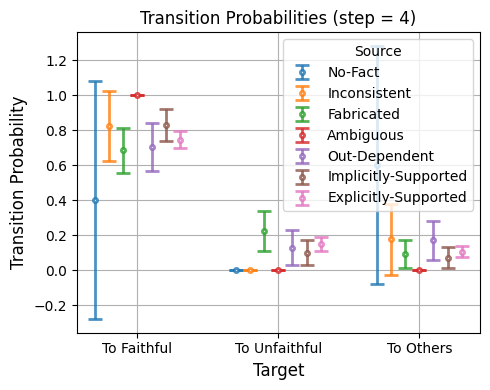

In [32]:
# 四跳步的转移矩阵
transition_matrix_4 = np.zeros((7, 7))
for i in range(len(sentences)):
    for j in range(len(sentences[i]) -4):
        current_state = label2num[sentences[i][j]['annotation'].lower()]
        next_state = label2num[sentences[i][j+4]['annotation'].lower()]
        transition_matrix_4[current_state][next_state] += 1
print(transition_matrix_4)
transition_count_matrix_4 = transition_matrix_4.copy()
print_transition_table(transition_count_matrix_4)
plot_transition_figure(transition_count_matrix_4, title='Transition Probabilities (step = 4)', name='step_4')

In [33]:
u, s, vh = np.linalg.svd(transition_matrix_3)
print(s)

[1.54381495e+00 6.03646167e-01 3.78359703e-01 1.22407390e-01
 2.71230310e-02 1.98807498e-02 1.47819807e-03]


qwen3-8b
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  0.  0.  3.  4.]
 [ 0.  2.  9.  0.  4.  4. 15.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  3.  0.  2.  1.  7.]
 [ 0.  2.  5.  0.  1.  4.  7.]
 [ 0.  6. 20.  0.  5.  8. 48.]]

\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    
    Explicitly-Supported & $0.64\pm0.10$ & $0.30\pm0.10$ \\
    Implicitly-Supported & $0.58\pm0.24$ & $0.37\pm0.24$ \\
    Fabricated & $0.56\pm0.18$ & $0.32\pm0.17$ \\
    Inconsistent & $0.78\pm0.34$ & $0.22\pm0.34$ \\
    \bottomrule
    
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    


/tmp/ipykernel_558769/2021377917.py:7: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:69: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)


phi-3-mini-4k-instruct
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  1.  0.  6.]
 [ 1.  0.  2.  0.  0.  3. 10.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  0.  0.  4.  6.]
 [ 2.  3.  9.  1.  1.  6. 46.]]

\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    
    Explicitly-Supported & $0.76\pm0.10$ & $0.18\pm0.09$ \\
    Implicitly-Supported & $0.83\pm0.25$ & $0.17\pm0.25$ \\
    Fabricated & $0.81\pm0.21$ & $0.12\pm0.18$ \\
    Inconsistent & $0.75\pm0.39$ & $0.12\pm0.30$ \\
    \bottomrule
    
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    


/tmp/ipykernel_558769/2021377917.py:7: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:69: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:80: RuntimeWarning: invalid value encountered in scalar divide
  err[i][0] = np.sqrt(p[i][0]*(1-p[i][0])/(transition_count_matrix[i].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[i].sum()-1)
/tmp/ipykernel_558769/2021377917.py:81: RuntimeWarning: invalid value encountered in scalar divide
  err[i][1] = np.sqrt(p[i][1]*(1-p[i][1])/(transition_count_matrix[i].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[i].sum()-1)
/tmp/ipykernel_558769/2021377917.py:82: RuntimeWarning: invalid value encountered in scalar divide
  err[i][2] = np.sqrt(p[i][2]*(1-p[i][2])/(transitio

qwen2.5-7b-instruct
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1.  2.]
 [ 0.  1.  5.  0.  0.  1.  7.]
 [ 0.  0.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  1.  0.  2.]
 [ 0.  0.  1.  0.  1.  4.  8.]
 [ 0.  3. 13.  1.  0.  9. 42.]]

\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    
    Explicitly-Supported & $0.75\pm0.11$ & $0.24\pm0.10$ \\
    Implicitly-Supported & $0.86\pm0.21$ & $0.07\pm0.15$ \\
    Fabricated & $0.57\pm0.30$ & $0.43\pm0.30$ \\
    Inconsistent & $0.75\pm0.80$ & $0.25\pm0.80$ \\
    \bottomrule
    
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    


/tmp/ipykernel_558769/2021377917.py:7: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:69: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:80: RuntimeWarning: invalid value encountered in scalar divide
  err[i][0] = np.sqrt(p[i][0]*(1-p[i][0])/(transition_count_matrix[i].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[i].sum()-1)
/tmp/ipykernel_558769/2021377917.py:81: RuntimeWarning: invalid value encountered in scalar divide
  err[i][1] = np.sqrt(p[i][1]*(1-p[i][1])/(transition_count_matrix[i].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[i].sum()-1)
/tmp/ipykernel_558769/2021377917.py:82: RuntimeWarning: invalid value encountered in scalar divide
  err[i][2] = np.sqrt(p[i][2]*(1-p[i][2])/(transitio

mistral-7b-instruct-v0.3
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  2.  0.  0.  0.  2.]
 [ 0.  1.  2.  0.  1.  3.  9.]
 [ 0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  1.  4.]
 [ 0.  1.  1.  0.  1.  2.  5.]
 [ 1.  2.  7.  0.  3.  5. 50.]]

\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    
    Explicitly-Supported & $0.81\pm0.10$ & $0.13\pm0.08$ \\
    Implicitly-Supported & $0.70\pm0.35$ & $0.20\pm0.30$ \\
    Fabricated & $0.75\pm0.24$ & $0.19\pm0.21$ \\
    Inconsistent & $0.40\pm0.68$ & $0.60\pm0.68$ \\
    \bottomrule
    
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    


/tmp/ipykernel_558769/2021377917.py:7: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:69: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:80: RuntimeWarning: invalid value encountered in scalar divide
  err[i][0] = np.sqrt(p[i][0]*(1-p[i][0])/(transition_count_matrix[i].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[i].sum()-1)
/tmp/ipykernel_558769/2021377917.py:81: RuntimeWarning: invalid value encountered in scalar divide
  err[i][1] = np.sqrt(p[i][1]*(1-p[i][1])/(transition_count_matrix[i].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[i].sum()-1)
/tmp/ipykernel_558769/2021377917.py:82: RuntimeWarning: invalid value encountered in scalar divide
  err[i][2] = np.sqrt(p[i][2]*(1-p[i][2])/(transitio

command-r-08-2024
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  4.  0.  0.  2.  7.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  2.  0.  6.]
 [ 0.  1.  2.  0.  1. 10.  6.]
 [ 0.  0. 11.  0.  3.  7. 41.]]

\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    
    Explicitly-Supported & $0.77\pm0.11$ & $0.18\pm0.10$ \\
    Implicitly-Supported & $0.80\pm0.19$ & $0.15\pm0.17$ \\
    Fabricated & $0.69\pm0.29$ & $0.31\pm0.29$ \\
    Inconsistent & $1.00\pmnan$ & $0.00\pmnan$ \\
    \bottomrule
    
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    


/tmp/ipykernel_558769/2021377917.py:7: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:27: RuntimeWarning: invalid value encountered in scalar divide
  err[3][0] = np.sqrt(p[3][0]*(1-p[3][0])/(transition_count_matrix[1].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[1].sum()-1)
/tmp/ipykernel_558769/2021377917.py:28: RuntimeWarning: invalid value encountered in scalar divide
  err[3][1] = np.sqrt(p[3][1]*(1-p[3][1])/(transition_count_matrix[1].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[1].sum()-1)
/tmp/ipykernel_558769/2021377917.py:69: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:80: RuntimeWarning: invalid value encountered in scalar divide
  err[i][0] = np.sqrt(p[i][0]*(1-p[i][0])/(transitio

meta-llama-3.1-8b-instruct
[[ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  1.  1.  8.]
 [ 0.  0.  0.  0.  0.  0.  2.]
 [ 0.  0.  1.  0.  2.  0.  2.]
 [ 0.  0.  2.  0.  1.  1.  5.]
 [ 0.  4.  4.  2.  4.  8. 40.]]

\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    
    Explicitly-Supported & $0.77\pm0.11$ & $0.13\pm0.09$ \\
    Implicitly-Supported & $0.67\pm0.38$ & $0.22\pm0.34$ \\
    Fabricated & $0.82\pm0.27$ & $0.09\pm0.20$ \\
    Inconsistent & $1.00\pmnan$ & $0.00\pmnan$ \\
    \bottomrule
    
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    


/tmp/ipykernel_558769/2021377917.py:27: RuntimeWarning: invalid value encountered in scalar divide
  err[3][0] = np.sqrt(p[3][0]*(1-p[3][0])/(transition_count_matrix[1].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[1].sum()-1)
/tmp/ipykernel_558769/2021377917.py:28: RuntimeWarning: invalid value encountered in scalar divide
  err[3][1] = np.sqrt(p[3][1]*(1-p[3][1])/(transition_count_matrix[1].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[1].sum()-1)
/tmp/ipykernel_558769/2021377917.py:80: RuntimeWarning: invalid value encountered in scalar divide
  err[i][0] = np.sqrt(p[i][0]*(1-p[i][0])/(transition_count_matrix[i].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[i].sum()-1)
/tmp/ipykernel_558769/2021377917.py:81: RuntimeWarning: invalid value encountered in scalar divide
  err[i][1] = np.sqrt(p[i][1]*(1-p[i][1])/(transition_count_matrix[i].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[i].sum()-1)
/tmp/ipykernel_558769/2021377917.py:82: RuntimeWarning: invalid 

meta-llama-3.1-70b-instruct
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  2.]
 [ 0.  0.  2.  0.  1.  3.  6.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  5.]
 [ 0.  0.  2.  0.  1.  1.  7.]
 [ 0.  3.  6.  0.  3.  7. 45.]]

\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    
    Explicitly-Supported & $0.81\pm0.10$ & $0.14\pm0.09$ \\
    Implicitly-Supported & $0.73\pm0.31$ & $0.18\pm0.27$ \\
    Fabricated & $0.75\pm0.29$ & $0.17\pm0.25$ \\
    Inconsistent & $1.00\pm0.00$ & $0.00\pm0.00$ \\
    \bottomrule
    
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    


/tmp/ipykernel_558769/2021377917.py:7: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:69: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)


deepseek-v3-0324
[[ 0.  0.  0.  0.  2.  0.  3.]
 [ 0.  0.  1.  0.  1.  1.  3.]
 [ 0.  1.  5.  0.  4.  3. 13.]
 [ 0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  4.  0. 11.  5. 19.]
 [ 1.  0.  5.  1.  2. 10. 15.]
 [ 3.  3. 13.  0. 14. 27. 71.]]

\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    
    Explicitly-Supported & $0.75\pm0.08$ & $0.12\pm0.06$ \\
    Implicitly-Supported & $0.74\pm0.16$ & $0.15\pm0.13$ \\
    Fabricated & $0.62\pm0.20$ & $0.23\pm0.17$ \\
    Inconsistent & $0.67\pm0.54$ & $0.17\pm0.43$ \\
    \bottomrule
    
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    


/tmp/ipykernel_558769/2021377917.py:80: RuntimeWarning: invalid value encountered in scalar divide
  err[i][0] = np.sqrt(p[i][0]*(1-p[i][0])/(transition_count_matrix[i].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[i].sum()-1)
/tmp/ipykernel_558769/2021377917.py:81: RuntimeWarning: invalid value encountered in scalar divide
  err[i][1] = np.sqrt(p[i][1]*(1-p[i][1])/(transition_count_matrix[i].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[i].sum()-1)
/tmp/ipykernel_558769/2021377917.py:82: RuntimeWarning: invalid value encountered in scalar divide
  err[i][2] = np.sqrt(p[i][2]*(1-p[i][2])/(transition_count_matrix[i].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[i].sum()-1)


gemini-1.5-flash-001
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  2.]
 [ 0.  1.  0.  1.  1.  1.  7.]
 [ 0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  1.  0.  6.]
 [ 0.  0.  0.  0.  0.  2.  6.]
 [ 0.  2.  7.  0.  6.  3. 67.]]

\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    
    Explicitly-Supported & $0.82\pm0.08$ & $0.11\pm0.07$ \\
    Implicitly-Supported & $1.00\pm0.00$ & $0.00\pm0.00$ \\
    Fabricated & $0.73\pm0.31$ & $0.09\pm0.20$ \\
    Inconsistent & $0.50\pm0.92$ & $0.50\pm0.92$ \\
    \bottomrule
    
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    


/tmp/ipykernel_558769/2021377917.py:7: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:69: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:80: RuntimeWarning: invalid value encountered in scalar divide
  err[i][0] = np.sqrt(p[i][0]*(1-p[i][0])/(transition_count_matrix[i].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[i].sum()-1)
/tmp/ipykernel_558769/2021377917.py:81: RuntimeWarning: invalid value encountered in scalar divide
  err[i][1] = np.sqrt(p[i][1]*(1-p[i][1])/(transition_count_matrix[i].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[i].sum()-1)
/tmp/ipykernel_558769/2021377917.py:82: RuntimeWarning: invalid value encountered in scalar divide
  err[i][2] = np.sqrt(p[i][2]*(1-p[i][2])/(transitio

gpt-3.5-turbo
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  1.  6.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  2.]
 [ 0.  1.  1.  0.  0.  0.  5.]
 [ 0.  0.  6.  0.  0.  5. 75.]]

\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    
    Explicitly-Supported & $0.93\pm0.05$ & $0.07\pm0.05$ \\
    Implicitly-Supported & $0.71\pm0.45$ & $0.29\pm0.45$ \\
    Fabricated & $0.88\pm0.30$ & $0.00\pm0.00$ \\
    Inconsistent & $1.00\pmnan$ & $0.00\pmnan$ \\
    \bottomrule
    
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    


/tmp/ipykernel_558769/2021377917.py:7: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:27: RuntimeWarning: invalid value encountered in scalar divide
  err[3][0] = np.sqrt(p[3][0]*(1-p[3][0])/(transition_count_matrix[1].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[1].sum()-1)
/tmp/ipykernel_558769/2021377917.py:28: RuntimeWarning: invalid value encountered in scalar divide
  err[3][1] = np.sqrt(p[3][1]*(1-p[3][1])/(transition_count_matrix[1].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[1].sum()-1)
/tmp/ipykernel_558769/2021377917.py:69: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:80: RuntimeWarning: invalid value encountered in scalar divide
  err[i][0] = np.sqrt(p[i][0]*(1-p[i][0])/(transitio

gpt-4o
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  6.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  7.]
 [ 0.  0.  2.  0.  1.  4.  7.]
 [ 0.  1.  5.  0.  5. 10. 71.]]

\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    
    Explicitly-Supported & $0.88\pm0.07$ & $0.07\pm0.05$ \\
    Implicitly-Supported & $0.79\pm0.25$ & $0.14\pm0.21$ \\
    Fabricated & $1.00\pm0.00$ & $0.00\pm0.00$ \\
    Inconsistent & $1.00\pmnan$ & $0.00\pmnan$ \\
    \bottomrule
    
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    


/tmp/ipykernel_558769/2021377917.py:7: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:27: RuntimeWarning: invalid value encountered in scalar divide
  err[3][0] = np.sqrt(p[3][0]*(1-p[3][0])/(transition_count_matrix[1].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[1].sum()-1)
/tmp/ipykernel_558769/2021377917.py:28: RuntimeWarning: invalid value encountered in scalar divide
  err[3][1] = np.sqrt(p[3][1]*(1-p[3][1])/(transition_count_matrix[1].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[1].sum()-1)
/tmp/ipykernel_558769/2021377917.py:69: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:80: RuntimeWarning: invalid value encountered in scalar divide
  err[i][0] = np.sqrt(p[i][0]*(1-p[i][0])/(transitio

gpt-5
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  2.  1.  5.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  6.  4. 17.]
 [ 0.  0.  1.  0.  5.  4. 10.]
 [ 0.  0.  7.  0.  6. 12. 65.]]

\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    
    Explicitly-Supported & $0.86\pm0.07$ & $0.08\pm0.06$ \\
    Implicitly-Supported & $0.70\pm0.22$ & $0.05\pm0.10$ \\
    Fabricated & $0.67\pm0.38$ & $0.11\pm0.26$ \\
    Inconsistent & $nan\pmnan$ & $nan\pmnan$ \\
    \bottomrule
    
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    


/tmp/ipykernel_558769/2021377917.py:7: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:69: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)


claude-3-5-sonnet-20240620
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  2.]
 [ 0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  3.  2.  9.]
 [ 0.  1.  0.  0.  5. 10. 12.]
 [ 1.  0.  2.  1.  6. 16. 57.]]

\begin{table}[thb]
    \centering
    \resizebox{\linewidth}{!}{

    \begin{tabular}{lcc}
    \toprule
    & \textbf{Faithful} & \textbf{Unfaithful} \\
    \midrule
    
    Explicitly-Supported & $0.88\pm0.07$ & $0.02\pm0.03$ \\
    Implicitly-Supported & $0.79\pm0.16$ & $0.04\pm0.07$ \\
    Fabricated & $1.00\pm0.00$ & $0.00\pm0.00$ \\
    Inconsistent & $1.00\pmnan$ & $0.00\pmnan$ \\
    \bottomrule
    
    \end{tabular}
    }
    \caption{The estimated transition probabilities of }
    \label{tab:transition-probabilities-}
\end{table}
    


/tmp/ipykernel_558769/2021377917.py:7: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:27: RuntimeWarning: invalid value encountered in scalar divide
  err[3][0] = np.sqrt(p[3][0]*(1-p[3][0])/(transition_count_matrix[1].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[1].sum()-1)
/tmp/ipykernel_558769/2021377917.py:28: RuntimeWarning: invalid value encountered in scalar divide
  err[3][1] = np.sqrt(p[3][1]*(1-p[3][1])/(transition_count_matrix[1].sum()-1))*stats.t.ppf(0.975, transition_count_matrix[1].sum()-1)
/tmp/ipykernel_558769/2021377917.py:69: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_count_matrix / transition_count_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_558769/2021377917.py:80: RuntimeWarning: invalid value encountered in scalar divide
  err[i][0] = np.sqrt(p[i][0]*(1-p[i][0])/(transitio

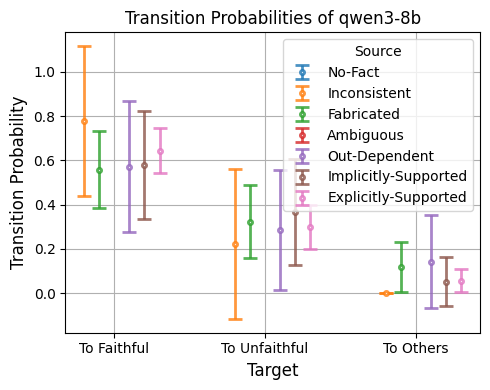

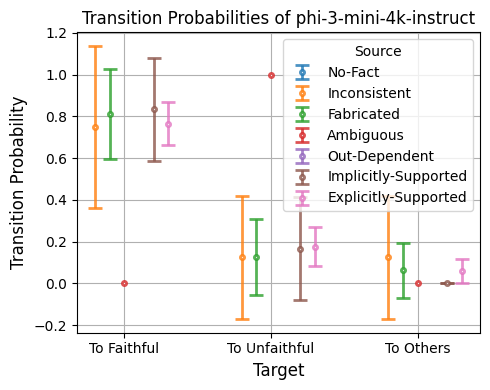

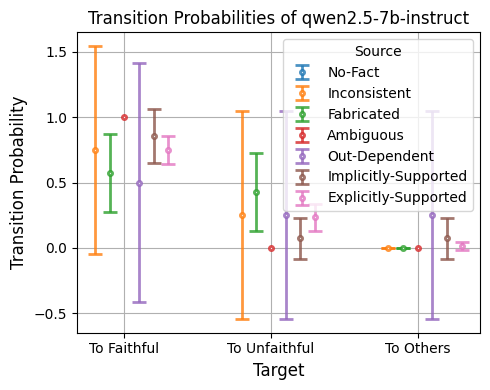

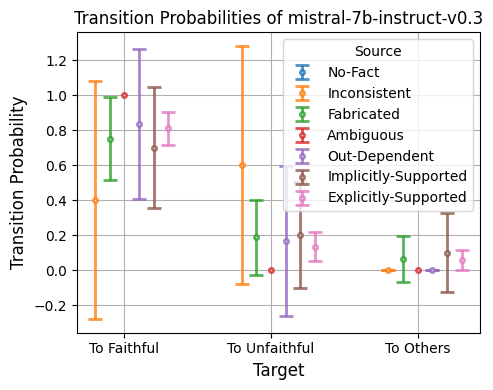

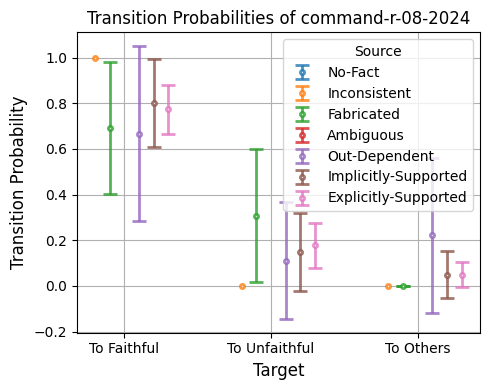

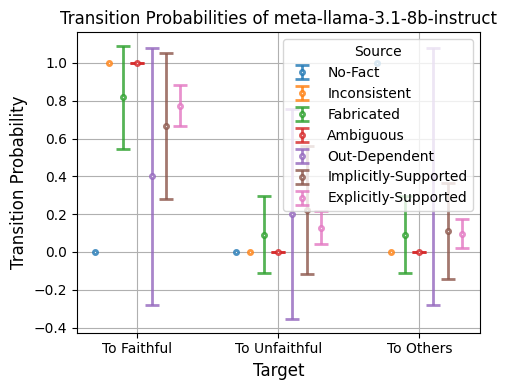

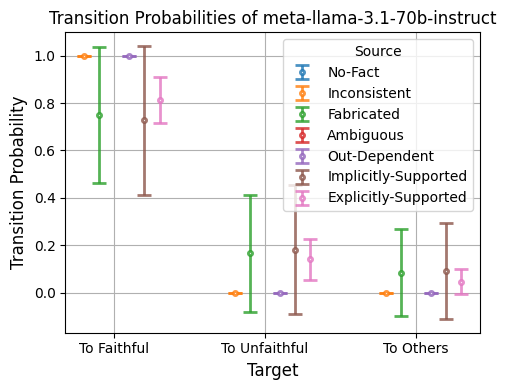

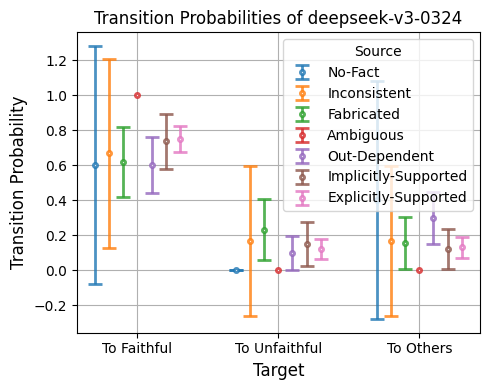

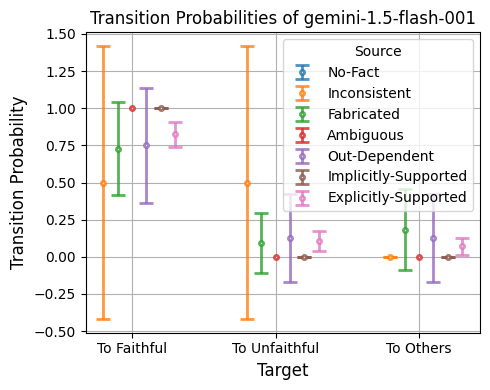

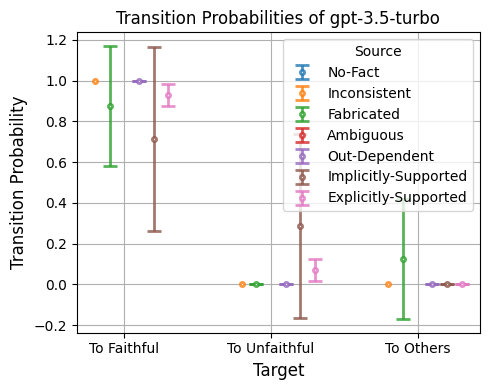

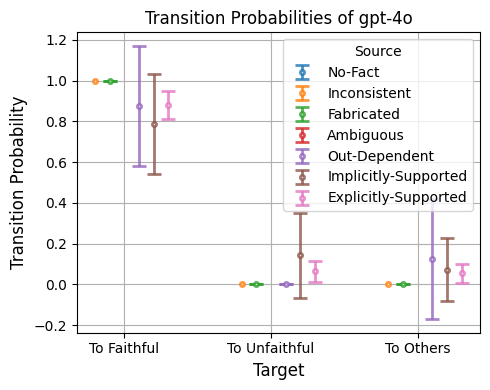

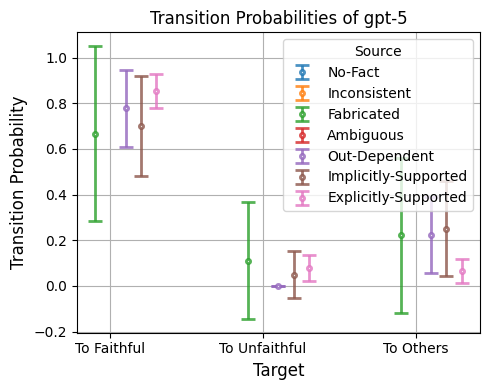

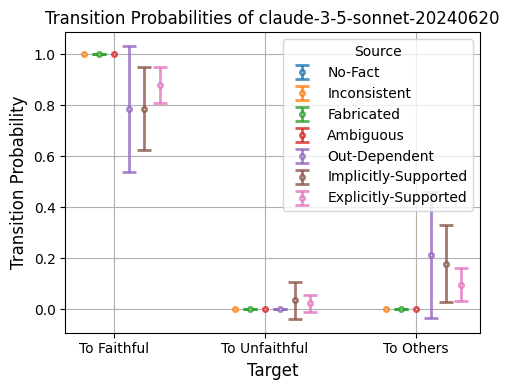

In [34]:
for model in models:
    print(model)
    transition_count_matrix_single_model = np.zeros((7, 7))

    for i in range(len(sentences)):
        if generator[i].split('/')[-1].lower() != model:
            continue
        for j in range(len(sentences[i]) -1):
            current_state = label2num.get(sentences[i][j]['annotation'].lower(), 3)
            next_state = label2num.get(sentences[i][j+1]['annotation'].lower(), 3)
            transition_count_matrix_single_model[current_state][next_state] += 1
    print(transition_count_matrix_single_model)
    print_transition_table(transition_count_matrix_single_model)
    plot_transition_figure(transition_count_matrix_single_model, title=f'Transition Probabilities of {model}', name=model)


# hallucination recall, precision, F1 @ different faithfulness threshold

Generating train split: 412 examples [00:00, 15225.14 examples/s]


confusion matrix: [[  39   10    0    0    0    7   10]
 [  25   84    2    0    4   42   75]
 [   1    2    0    0    0    4   15]
 [   0    5    0    8    0    0    3]
 [   4   24    0    0   16   44   72]
 [   1   27    1    5    1  108  118]
 [   5   60    3    1   14  194 1010]]
balanced accuracy: 0.7350619114510171
hallucination recall: 0.5302013422818792
hallucination precision: 0.6294820717131474
hallucination detection f1: 0.575591985428051
rank loss: 0.3604321114293988
macro f1: 0.3908858960530694
confusion matrix: [[  39   10    0    0    0    7   10]
 [  25   84    2    0    4   42   75]
 [   1    2    0    0    0    4   15]
 [   0    5    0    8    0    0    3]
 [   4   24    0    0   16   44   72]
 [   1   27    1    5    1  108  118]
 [   5   60    3    1   14  194 1010]]
balanced accuracy: 0.7371256264849211
hallucination recall: 0.5369127516778524
hallucination precision: 0.622568093385214
hallucination detection f1: 0.5765765765765766
rank loss: 0.3604321114293988
mac

 25%|██▌       | 1/4 [00:14<00:44, 14.80s/it]

rank loss: 0.3604321114293988
macro f1: 0.3908858960530694


Generating train split: 412 examples [00:00, 15834.96 examples/s]


confusion matrix: [[  11   41    0    0    0    3   10]
 [   5  132    0    0    3   19   76]
 [   0    4    0    0    0    0   25]
 [   1    3    0    4    1    0    8]
 [   0   34    0    0    4   15  107]
 [   1   33    0    1    3   37  178]
 [   1   68    0    0    1   93 1122]]
balanced accuracy: 0.7815149544863459
hallucination recall: 0.63
hallucination precision: 0.6472602739726028
hallucination detection f1: 0.6385135135135135
rank loss: 0.34106311660485367
macro f1: 0.3037908074662827
confusion matrix: [[  11   41    0    0    0    3   10]
 [   5  132    0    0    3   19   76]
 [   0    4    0    0    0    0   25]
 [   1    3    0    4    1    0    8]
 [   0   34    0    0    4   15  107]
 [   1   33    0    1    3   37  178]
 [   1   68    0    0    1   93 1122]]
balanced accuracy: 0.7815149544863459
hallucination recall: 0.63
hallucination precision: 0.6472602739726028
hallucination detection f1: 0.6385135135135135
rank loss: 0.34106311660485367
macro f1: 0.303790807466282

 50%|█████     | 2/4 [00:30<00:30, 15.34s/it]

rank loss: 0.34106311660485367
macro f1: 0.3037908074662827


Generating train split: 412 examples [00:00, 10417.43 examples/s]


confusion matrix: [[   5   14    0    1    0    8   30]
 [   8   22    0    0    0   45  195]
 [   0    0    0    0    0    0    1]
 [   0   13    0    8    0   82 1018]
 [   0    2    0    0    0    5   75]
 [   0    1    1    1    0   16   97]
 [   0    1    0    1    0   14  379]]
balanced accuracy: 0.5727381747887929
hallucination recall: 0.14939024390243902
hallucination precision: 0.9607843137254902
hallucination detection f1: 0.25857519788918204
rank loss: 0.46758818315346573
macro f1: 0.10702986994384674
confusion matrix: [[   5   14    0    1    0    8   30]
 [   8   22    0    0    0   45  195]
 [   0    0    0    0    0    0    1]
 [   0   13    0    8    0   82 1018]
 [   0    2    0    0    0    5   75]
 [   0    1    1    1    0   16   97]
 [   0    1    0    1    0   14  379]]
balanced accuracy: 0.5717597012075796
hallucination recall: 0.14939024390243902
hallucination precision: 0.9423076923076923
hallucination detection f1: 0.25789473684210523
rank loss: 0.467588183153

 75%|███████▌  | 3/4 [00:48<00:16, 16.37s/it]

rank loss: 0.46758818315346573
macro f1: 0.10702986994384674


Generating train split: 412 examples [00:00, 9426.38 examples/s]


confusion matrix: [[  17   15    0    1    0    5   20]
 [  11   62    0    0    3   62  132]
 [   0    0    0    0    0    0    1]
 [   4   17    0    2    0   25   82]
 [   0    4    0    0    2    5   71]
 [   1    6    0    1    6   67  158]
 [   2   20    0    2    0  234 1005]]
balanced accuracy: 0.6504071806696762
hallucination recall: 0.3201219512195122
hallucination precision: 0.7835820895522388
hallucination detection f1: 0.4545454545454545
rank loss: 0.41000094975781176
macro f1: 0.24268864838680498
confusion matrix: [[  17   15    0    1    0    5   20]
 [  11   62    0    0    3   62  132]
 [   0    0    0    0    0    0    1]
 [   4   17    0    2    0   25   82]
 [   0    4    0    0    2    5   71]
 [   1    6    0    1    6   67  158]
 [   2   20    0    2    0  234 1005]]
balanced accuracy: 0.6504071806696762
hallucination recall: 0.3201219512195122
hallucination precision: 0.7835820895522388
hallucination detection f1: 0.4545454545454545
rank loss: 0.4100009497578117

100%|██████████| 4/4 [01:03<00:00, 15.86s/it]

rank loss: 0.41000094975781176
macro f1: 0.24268864838680498


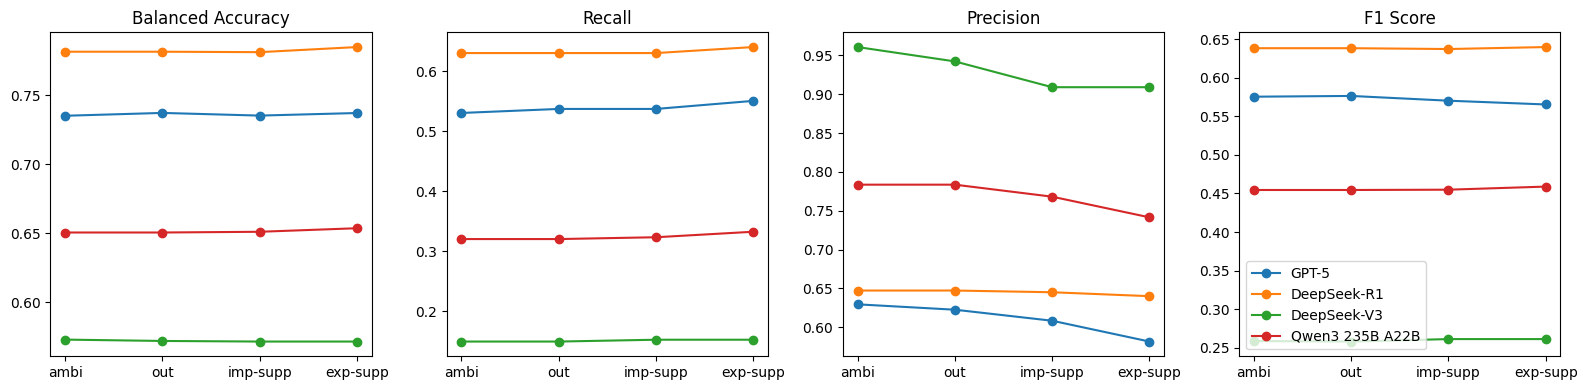

In [ ]:
from datasets import load_dataset
from tqdm import tqdm

from utils import fine_grained_evaluate


data_files = {
    'GPT-5': '/home/dingqiang/hallucination_detection/zero_shot_results/verigray_sentence_level_results_gpt-5.jsonl',
    'DeepSeek-R1': '/home/dingqiang/hallucination_detection/zero_shot_results/verigray_sentence_level_results_r1.jsonl',
    'DeepSeek-V3': '/home/dingqiang/hallucination_detection/zero_shot_results/verigray_sentence_level_results_deepseek_v3.jsonl',
    'Qwen3 235B A22B': '/home/dingqiang/hallucination_detection/zero_shot_results/verigray_sentence_level_results_qwen3_235b_a22b.jsonl',
}

# figure with 4x1 subplots
# subplot 1 for balanced accuracy
# subplot 2 for recall
# subplot 3 for precision
# subplot 4 for f1 score
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

thresholds = [2,3,4,5]
threshold_labels = ['ambi', 'out', 'imp-supp', 'exp-supp']

for model_name, file_path in tqdm(data_files.items()):
    ds = load_dataset('json', data_files=data_files[model_name])['train']
    balanced_accs = []
    recalls = []
    precisions = []
    f1s = []
    for thresh in thresholds:
        results = fine_grained_evaluate(ds, thresh, print_results=True)
        balanced_accs.append(results['balanced_acc'])
        recalls.append(results['hallucination_recall'])
        precisions.append(results['hallucination_precision'])
        f1s.append(results['hallucination_f1'])
    ax1.plot(threshold_labels, balanced_accs, marker='o', label=model_name)
    ax2.plot(threshold_labels, recalls, marker='o', label=model_name)
    ax3.plot(threshold_labels, precisions, marker='o', label=model_name)
    ax4.plot(threshold_labels, f1s, marker='o', label=model_name)


ax1.set_title('Balanced Accuracy')
# ax1.set_ylabel('Balanced Accuracy')
# ax1.set_xlabel('Threshold')
# ax1.legend()
ax2.set_title('Recall')
# ax2.set_ylabel('Recall')
# ax2.set_xlabel('Threshold')
# ax2.legend()
ax3.set_title('Precision')
# ax3.set_ylabel('Precision')
# ax3.set_xlabel('Threshold')
# ax3.legend()
ax4.set_title('F1 Score')
# ax4.set_ylabel('F1 Score')
# ax4.set_xlabel('Threshold')
ax4.legend()
plt.tight_layout()
plt.show()
# plt.savefig('figs/zero_shot_model_comparison.pdf')

Generating train split: 412 examples [00:00, 19839.42 examples/s]
Generating train split: 412 examples [00:00, 23662.56 examples/s]
Generating train split: 412 examples [00:00, 19947.29 examples/s]
Generating train split: 412 examples [00:00, 21633.12 examples/s]
Generating train split: 412 examples [00:00, 29761.69 examples/s]
Generating train split: 412 examples [00:00, 2615.45 examples/s]
6it [01:09, 11.54s/it]


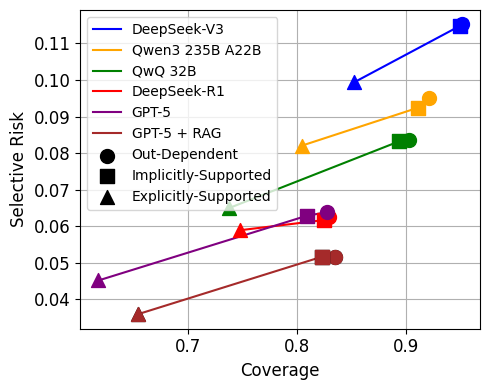

In [ ]:
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

from utils import fine_grained_evaluate


data_files = {
    'DeepSeek-V3': '/home/dingqiang/hallucination_detection/zero_shot_results/verigray_sentence_level_results_deepseek_v3_2_reparsed.jsonl',
    'Qwen3 235B A22B': '/home/dingqiang/hallucination_detection/zero_shot_results/verigray_sentence_level_results_qwen3_235b_a22b_2_reparsed.jsonl',
    'QwQ 32B': '/home/dingqiang/hallucination_detection/zero_shot_results/verigray_sentence_level_results_qwq-32b_2_reparsed.jsonl',
    'DeepSeek-R1': '/home/dingqiang/hallucination_detection/zero_shot_results/verigray_sentence_level_results_r1_2_reparsed.jsonl',
    'GPT-5': '/home/dingqiang/hallucination_detection/zero_shot_results/verigray_sentence_level_results_gpt-5_reparsed.jsonl',
    'GPT-5 + RAG': '/home/dingqiang/hallucination_detection/verify_with_rag_results/verigray_sentence_level_results_gpt-5_no_old.jsonl'
}

fig = plt.figure(figsize=(5, 4))
# ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)
markers = ['o', 's', '^']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

thresholds = [4,5,6]
threshold_labels = ['Out-Dependent', 'Implicitly-Supported', 'Explicitly-Supported']
for j, (model_name, file_path) in tqdm(enumerate(data_files.items())):
    ds = load_dataset('json', data_files=data_files[model_name])['train']
    selective_risks = []
    coverages = []
    for thresh in thresholds:
        results = fine_grained_evaluate(ds, thresh, print_results=False)
        confusion = results['confusion_matrix']
        selective_risks.append(confusion[:2, thresh:].sum() / confusion[:, thresh:].sum())
        coverages.append(confusion[:, thresh:].sum() / confusion.sum())
    plt.plot(coverages, selective_risks, marker=',', label=model_name, color=colors[j])
    # ax1.plot(thresholds, selective_risks, marker='o', label=model_name)
    # ax2.plot(thresholds, coverages, marker='o', label=model_name)
    for i in range(len(thresholds)):
        if j == len(data_files)-1:
            plt.scatter(coverages[i], selective_risks[i], marker=markers[i], color='black', s=100, zorder=5, label=threshold_labels[i])
        plt.scatter(coverages[i], selective_risks[i], marker=markers[i], color=colors[j], s=100, zorder=5)

plt.xlabel('Coverage', fontsize=12)
plt.ylabel('Selective Risk', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('figs/evaluate_selective_prediction.pdf')

# 细粒度 unfaithfulness 分类的各类 F1 的雷达图

In [ ]:
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from utils import fine_grained_evaluate

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


data_files = {
    'DeepSeek-V3': '/home/dingqiang/hallucination_detection/zero_shot_results/verigray_sentence_level_results_deepseek_v3_2_reparsed.jsonl',
    'Qwen3 235B A22B': '/home/dingqiang/hallucination_detection/zero_shot_results/verigray_sentence_level_results_qwen3_235b_a22b_2_reparsed.jsonl',
    'QwQ 32B': '/home/dingqiang/hallucination_detection/zero_shot_results/verigray_sentence_level_results_qwq-32b_2_reparsed.jsonl',
    'DeepSeek-R1': '/home/dingqiang/hallucination_detection/zero_shot_results/verigray_sentence_level_results_r1_2_reparsed.jsonl',
    'GPT-5': '/home/dingqiang/hallucination_detection/zero_shot_results/verigray_sentence_level_results_gpt-5_reparsed.jsonl',
    'GPT-5 + RAG': '/home/dingqiang/hallucination_detection/verify_with_rag_results/verigray_sentence_level_results_gpt-5_no_old.jsonl'
}
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

classes = [
    'Contradicting',
    'Fabricated',
    'Ambiguous',
    'No-Fact', 
    'Out-Dependent',
    'Implicitly-Supported',
    'Explicitly-Supported'
]


0it [00:00, ?it/s]

6it [00:28,  4.71s/it]


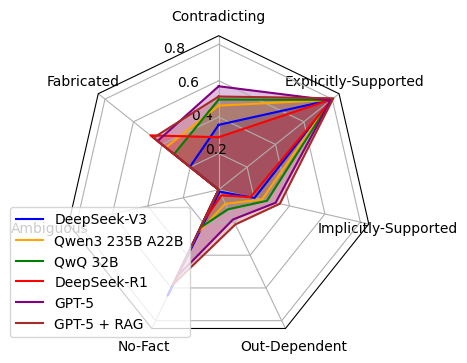

In [38]:

N = len(classes)
theta = radar_factory(N, frame='polygon')
fig, ax = plt.subplots(figsize=(5,4), subplot_kw=dict(projection="radar"))

for j, (model_name, file_path) in tqdm(enumerate(data_files.items())):
    ds = load_dataset('json', data_files=data_files[model_name])['train']
    results = fine_grained_evaluate(ds, 5, print_results=False)
    confusion = results['confusion_matrix']
    # calculate class-wise F1
    class_f1s = []
    for i in range(confusion.shape[0]):
        p = confusion[i,i] / confusion[:,i].sum() if confusion[:,i].sum() > 0 else 0
        r = confusion[i,i] / confusion[i,:].sum() if confusion[i,:].sum() > 0 else 0
        f1 = 2*p*r/(p+r) if p+r > 0 else 0
        class_f1s.append(f1)
    ax.plot(theta, class_f1s, label=model_name, color=colors[j])
    ax.fill(theta, class_f1s, alpha=0.25, label='_nolegend_', color=colors[j])

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_xticks(np.linspace(0, 2*np.pi, len(classes), endpoint=False))
ax.set_xticklabels(classes)

plt.legend(loc='lower left', bbox_to_anchor=(-0.2, 0))
plt.savefig('figs/class_F1.pdf')


0it [00:00, ?it/s]

6it [00:26,  4.40s/it]


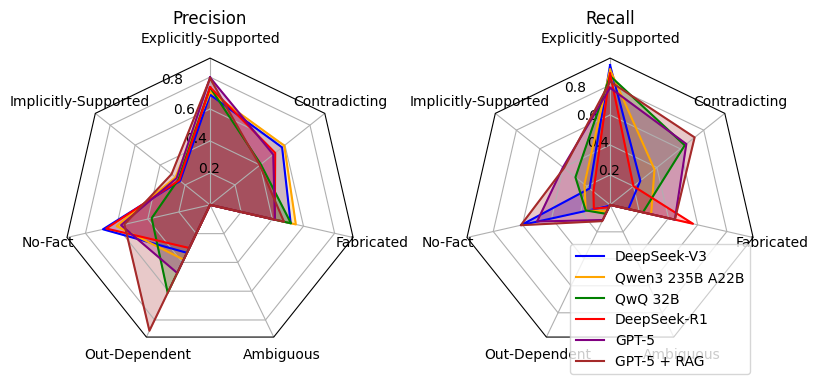

In [39]:
class_shuffle = [6,5,3,4,2,1,0]

N = len(classes)
theta = radar_factory(N, frame='polygon')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), subplot_kw=dict(projection="radar"))

for j, (model_name, file_path) in tqdm(enumerate(data_files.items())):
    ds = load_dataset('json', data_files=data_files[model_name])['train']
    results = fine_grained_evaluate(ds, 5, print_results=False)
    confusion = results['confusion_matrix']
    # calculate class-wise F1
    class_ps = []
    class_rs = []
    for i in range(confusion.shape[0]):
        p = confusion[i,i] / confusion[:,i].sum() if confusion[:,i].sum() > 0 else 0
        r = confusion[i,i] / confusion[i,:].sum() if confusion[i,:].sum() > 0 else 0
        # f1 = 2*p*r/(p+r) if p+r > 0 else 0
        class_ps.append(p)
        class_rs.append(r)
    class_ps = [class_ps[i] for i in class_shuffle]
    class_rs = [class_rs[i] for i in class_shuffle]
    ax1.plot(theta, class_ps, label=model_name, color=colors[j])
    ax1.fill(theta, class_ps, alpha=0.25, label='_nolegend_', color=colors[j])
    ax2.plot(theta, class_rs, label=model_name, color=colors[j])
    ax2.fill(theta, class_rs, alpha=0.25, label='_nolegend_', color=colors[j])

ax1.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax1.set_xticks(np.linspace(0, 2*np.pi, len(classes), endpoint=False))
ax1.set_xticklabels([classes[i] for i in class_shuffle])
ax1.set_title('Precision')
ax2.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax2.set_xticks(np.linspace(0, 2*np.pi, len(classes), endpoint=False))
ax2.set_xticklabels([classes[i] for i in class_shuffle])
ax2.set_title('Recall')
ax2.legend(loc='lower right', bbox_to_anchor=(1.0, -0.1))
plt.tight_layout(pad=0)
plt.savefig('figs/class_PR.pdf')

# 展示 confusion matrix

In [40]:
import numpy as np


confusion = np.array(
    [[  39, 5, 0,1, 0, 4, 5],
    [  49, 103, 1, 0, 1, 35,  44],
    [   1,   1, 0, 0, 0,  0,   7],
    [   2,   1, 0,11, 0,  0,   3],
    [   2,  19, 0, 0,23, 39,  93],
    [   1,  30, 0, 7, 0,107, 126],
    [   4,  58, 1, 1, 0,162,1058]]
)

In [41]:
confusion.sum()

np.int64(2044)

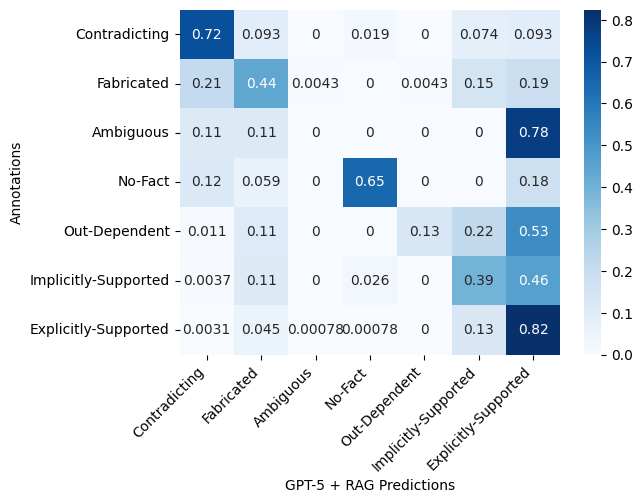

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(figsize=(7, 5))
fig.subplots_adjust(left=0.27, bottom=0.3, right=0.95, top=0.99)  # 调整边距

sns.heatmap(confusion/confusion.sum(axis=1, keepdims=True), annot=True, cmap='Blues', xticklabels=['Contradicting', 'Fabricated', 'Ambiguous', 'No-Fact', 'Out-Dependent', 'Implicitly-Supported', 'Explicitly-Supported'], yticklabels=['Contradicting', 'Fabricated', 'Ambiguous', 'No-Fact', 'Out-Dependent', 'Implicitly-Supported', 'Explicitly-Supported'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('GPT-5 + RAG Predictions')
plt.ylabel('Annotations')

plt.savefig('figs/verify_with_rag_gpt-5_confusion_matrix.pdf')